# Generate Excel report and bar chart

In [25]:
import json
import pandas as pd

with open("data/monitored_emails.json") as fh:
    emails = json.load(fh)
with open("data/breach_information.json") as fh:
    breaches = json.load(fh)

user_info_tags = ["Email addresses", "Names", "Usernames", "Phone numbers", "Social media profiles"]
credential_tags = ["Passwords", "Auth tokens", "Password hints", "Email messages", "Survey results", "Website activity"]

combined = []
for email, data in emails.items():
    for breach in data["breaches"]:
        data = {
                "Account": email,
                "AccountName": email[:email.rfind("@")],
                "AccountDoman": email[email.rfind("@")+1:],
                "BreachTitle": breaches[breach]["Title"],
                "BreachDate": breaches[breach]["BreachDate"],
                "Domain": breaches[breach]["Domain"],
                "LeakedUserInfo": ", ".join([item for item in breaches[breach]["DataClasses"] if item in user_info_tags]),
                "LeakedCredentials": ", ".join([item for item in breaches[breach]["DataClasses"] if item in credential_tags]),
                "Verified": breaches[breach]["IsVerified"],
                "CompromisedData": ", ".join(breaches[breach]["DataClasses"]),
                "IsSpamList": breaches[breach]["IsSpamList"],
                "IsSensitive": breaches[breach]["IsSensitive"],
                "IsMalware": breaches[breach]["IsMalware"]
        }
        combined.append(data)

df = pd.DataFrame(combined)
df2 = pd.DataFrame(breaches).T


with pd.ExcelWriter("Compromised account report.xlsx") as writer: 
    df.to_excel(writer, sheet_name="CompromisedAccounts", index=False)
    fname = input("Filepath of previous report: ")
    try:
        previous = pd.read_excel(fname).T.to_dict()
        prev_index = {f"{previous[idx]['Account']}_{previous[idx]['BreachTitle']}":idx for idx in previous}
        new_findings = []
        for acct in combined:
            search_term = f"{acct['Account']}_{acct['BreachTitle']}"
            if search_term not in prev_index:
                new_findings.append(acct)
        df_new = pd.DataFrame(new_findings)
        if not df_new.empty:
            df_new.to_excel(writer, sheet_name="Changes", index=False)
    except:
        print("Failed to load previous file, skipping")
    
    df2[["Title", "Domain", "BreachDate", "PwnCount", 
        "DataClasses", "IsVerified", "IsFabricated", "IsSensitive", 
        "IsRetired", "IsSpamList", "IsMalware", "KIT_NOTIFICATION", "Description"]].to_excel(writer, sheet_name="BreachInfo", index=False)
    

<Axes: ylabel='BreachTitle'>

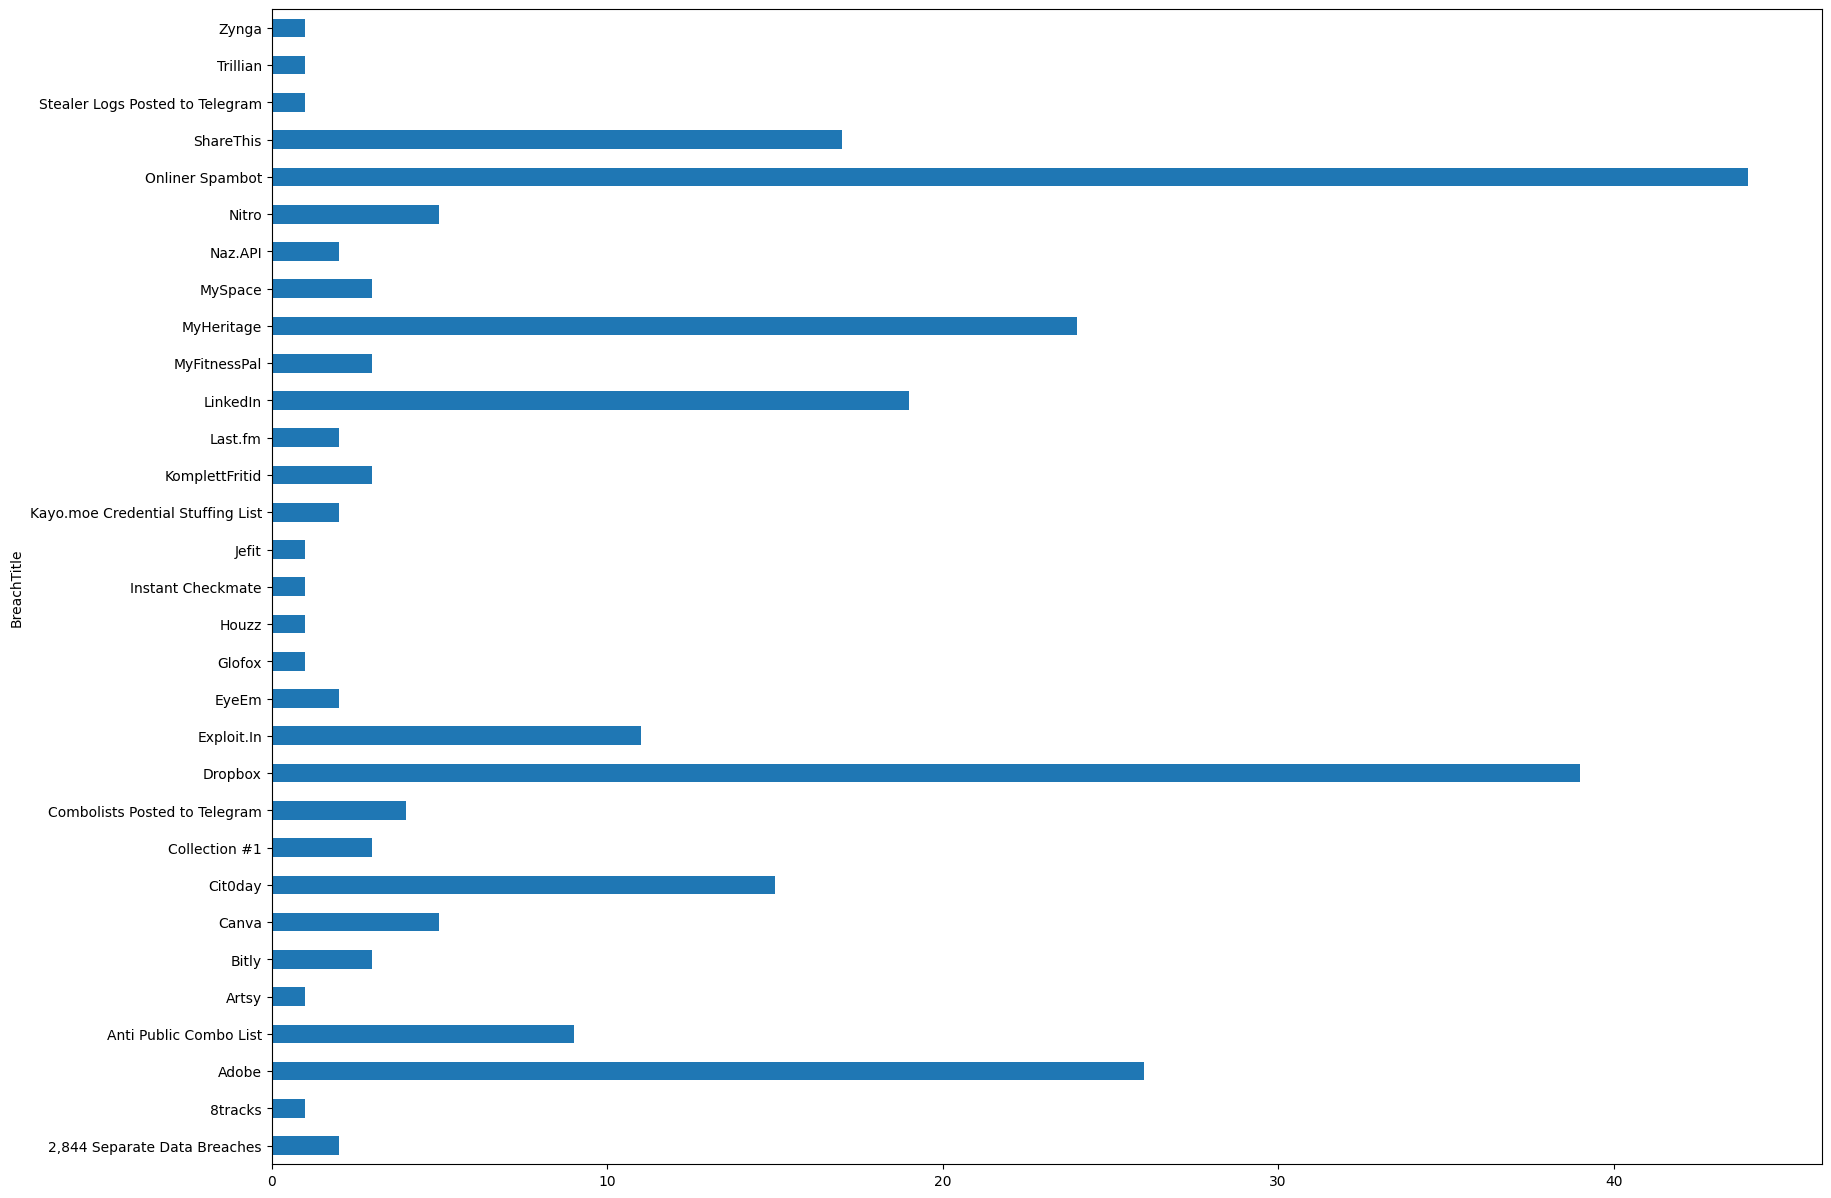

In [26]:
df
sel = [False if not val else True for val in df.LeakedCredentials]
df[sel].groupby("BreachTitle").BreachTitle.count().plot(kind="barh", figsize=(20,15))